In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_recall_curve, recall_score)
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
data = pd.read_csv('Breast_cancer_data.csv')
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.25, random_state=42
)

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [4]:
# Combine for resampling
df = pd.DataFrame(X_train)
df['label'] = y_train
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]
# Upsample malignant to 3x majority
df_min_up = resample(df_minority, replace=True, n_samples=len(df_majority)*3, random_state=42)
df_resampled = pd.concat([df_majority, df_min_up])
X_train_up = df_resampled.drop('label', axis=1).values
y_train_up = df_resampled['label'].values
print('Resampled distribution:', pd.Series(y_train_up).value_counts())

Resampled distribution: 1    381
0    127
Name: count, dtype: int64


In [5]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1-y_true) * tf.math.log(1-y_pred)
        weight = alpha * y_true * tf.math.pow(1-y_pred, gamma) + (1-alpha)*(1-y_true)*tf.math.pow(y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss

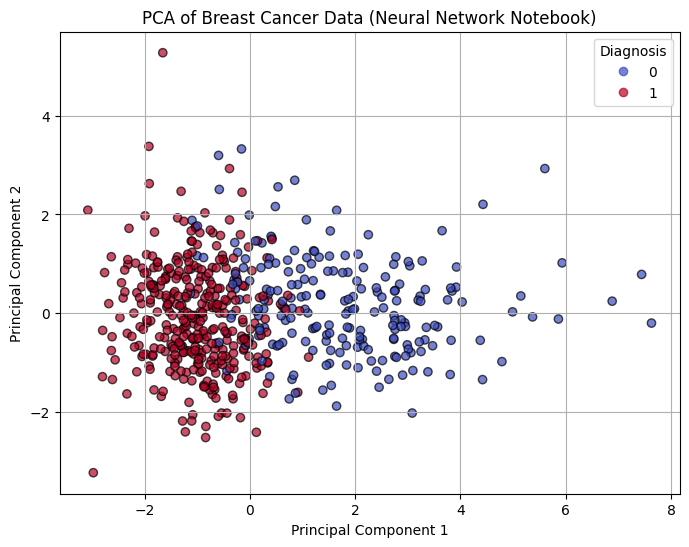

Explained variance ratio (PC1, PC2): [0.63117561 0.21585078]


In [11]:
# Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Recreate full dataset for PCA
X_full = np.vstack((X_train, X_val, X_test))
y_full = np.hstack((y_train, y_val, y_test))

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_full, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Breast Cancer Data (Neural Network Notebook)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Diagnosis")
plt.show()

# Print explained variance
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)


In [6]:
def build_model(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,)), BatchNormalization(), Activation('relu'), Dropout(0.4),
        Dense(64), BatchNormalization(), Activation('relu'), Dropout(0.3),
        Dense(32), Activation('relu'), Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss=focal_loss(alpha=0.3, gamma=2.0),
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model
model = build_model(X_train_up.shape[1])
model.summary()

C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]
history = model.fit(
    X_train_up, y_train_up,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6667 - loss: 0.0759 - val_accuracy: 0.9386 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8238 - loss: 0.0418 - val_accuracy: 0.9474 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9033 - loss: 0.0282 - val_accuracy: 0.9474 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8639 - loss: 0.0324 - val_accuracy: 0.9474 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9051 - loss: 0.0265 - val_accuracy: 0.9474 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9196 - loss: 0.0205 - val_accuracy: 0.9649 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8856 - loss: 0.0319 - val_ac

In [8]:
y_val_prob = model.predict(X_val).ravel()
prec, rec, thr = precision_recall_curve(y_val, y_val_prob)
idx = np.where(rec >= 1.0)[0]
best_thresh = thr[idx[-1]] if len(idx) else 0.5
print(f'Optimal Threshold: {best_thresh:.3f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Optimal Threshold: 0.331


In [9]:
y_test_prob = model.predict(X_test).ravel()
y_test_pred = (y_test_prob >= best_thresh).astype(int)
print('Recall on positive cancer test:', recall_score(y_test, y_test_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Recall on positive cancer test: 0.9583333333333334
Confusion Matrix:
 [[36  6]
 [ 3 69]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        42
           1       0.92      0.96      0.94        72

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



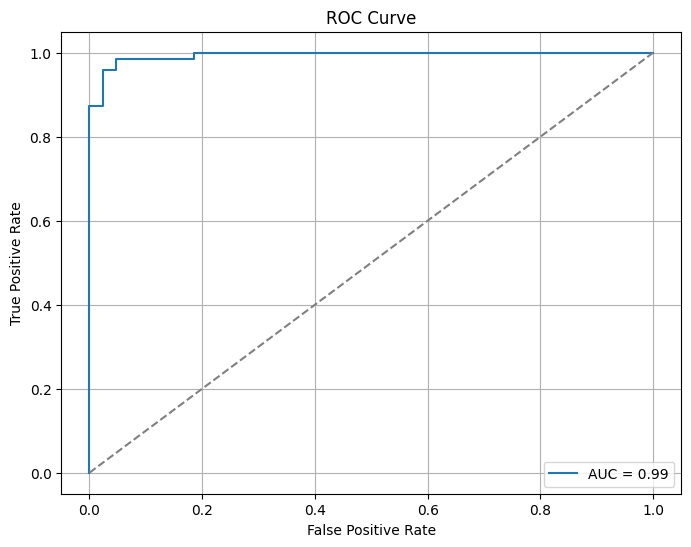

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
auc_score = roc_auc_score(y_val, y_val_prob)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
